In [63]:
import numpy as np
import matplotlib.pyplot as plt

import warnings
import pickle
import katdal
import katpoint
import scape
import logging, os

from katsdpscripts.reduction.analyse_point_source_scans import reduce_and_plot
from katsdpscripts.reduction.analyse_point_source_scans import extract_cal_dataset,reduce_compscan

%matplotlib inline

In [64]:
filename='/var/kat/archive/data/MeerKATAR1/telescope_products/2016/04/05/1459835201.h5'
filename='/var/kat/archive/data/MeerKATAR1/telescope_products/2016/04/05/1459838971.h5'
filename='/var/kat/archive/data/MeerKATAR1/telescope_products/2016/04/05/1459842528.h5'
#antenna_name='m063'
antenna_name='m062'
#antenna_name='m031'
antenna_name='m034'
receptor_serial={'m062':{'band':'l', 'serial':4001},'m063':{'band':'l', 'serial':4002},
                 'm031':{'band':'l', 'serial':4005},'m034':{'band':'l', 'serial':4010}}

In [65]:
# Default output file names are based on input file name
dataset_name = os.path.splitext(os.path.basename(filename))[0]
outfilebase = '%s_%s_point_source_scans' % (dataset_name,antenna_name)
# Default values for Ku-band need to be updated if data uses this band
ku_band=False
# Baseline to load (e.g. 'ant1' for antenna 1 or 'ant1,ant2' for 1-2 baseline),
# default is first single-dish baseline in file
baseline='sd'
# Range of frequency channels to keep (zero-based, specified as 'start,end', if None the default is 50% of the bandpass)
freq_chans=None
# Number of Monte Carlo iterations to estimate uncertainty (20-30 suggested, default off)
mc_iterations=1
# Time offset to add to DBE timestamps, in seconds
time_offset=0.0

# Optional pickle file with boolean array specifying channels to mask
channel_mask ='/var/kat/katsdpscripts/RTS/rfi_mask.pickle'

# Name of directory containing noise diode model files
nd_models = '/var/kat/katconfig/user/noise-diode-models/mkat/'
# Name of the directory containing pointing model parameters
pt_models = '/var/kat/katconfig/user/pointing-models/mkat/'

In [66]:
class Storage(dict):
    def __getattr__(self, key):
        try:
            return self[key]
        except KeyError, k:
            raise AttributeError, k

    def __setattr__(self, key, value):
        self[key] = value

    def __delattr__(self, key):
        try:
            del self[key]
        except KeyError, k:
            raise AttributeError, k

    def __repr__(self):
        return '<Storage ' + dict.__repr__(self) + '>'

opts = Storage()
opts['baseline'] = baseline
opts['nd_models'] = nd_models
opts['channel_mask'] = channel_mask
opts['ku_band'] = ku_band
opts['batch'] = False
opts['keep_all'] = True
opts['mc_iterations'] = mc_iterations
opts['plot_spectrum'] = True
opts['freq_chans'] = freq_chans
opts['time_offset'] = time_offset
opts['pointing_model'] = pt_models
opts['outfilebase'] = outfilebase

Loading HDF5 file /var/kat/archive/data/MeerKATAR1/telescope_products/2016/04/05/1459842528.h5 into scape and reducing the data
keep_all=True,main_compscan.beam.is_valid=False , keep=True 


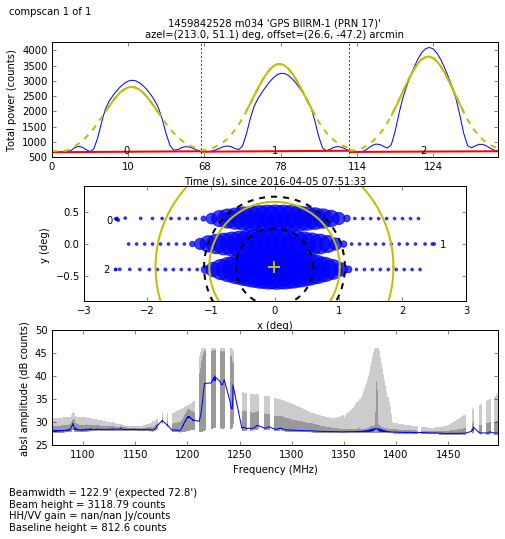

In [67]:
print ('Loading HDF5 file %s into scape and reducing the data'%filename)
h5file = katdal.open(filename)

kwargs={}

#Force centre freqency if ku-band option is set
if ku_band: kwargs['centre_freq'] = 12.5005e9

# Produce canonical version of baseline string (remove duplicate antennas)
baseline_ants = baseline.split(',')
if len(baseline_ants) == 2 and baseline_ants[0] == baseline_ants[1]: baseline = baseline_ants[0]

# Load data set
if antenna_name not in [ant.name for ant in h5file.ants]:
    raise RuntimeError('Cannot find antenna %s in dataset'%antenna_name)

h5file.select(ants=antenna_name, corrprods='auto',scans='scan')
ant = h5file.ants[0]
  
try:
    dataset = scape.DataSet(h5file, baseline="%s" % (ant.name,), nd_models=nd_models, time_offset=time_offset, **kwargs)
except IOError:
    dataset = scape.DataSet(h5file, baseline="%s" % (ant.name,),
                            nd_h_model='/var/kat/katconfig/user/noise-diode-models/mkat/rx.l.4.h.csv',
                            nd_v_model='/var/kat/katconfig/user/noise-diode-models/mkat/rx.l.4.v.csv')

# Select frequency channels and setup defaults if not specified
num_channels = len(dataset.channel_select)
if freq_chans is None:
    # Default is drop first and last 25% of the bandpass
    start_chan = num_channels // 4
    end_chan   = start_chan * 3
else:
    start_chan = int(freq_chans.split(',')[0])
    end_chan = int(freq_chans.split(',')[1])
    chan_select = range(start_chan,end_chan+1)

# Check if a channel mask is specified and apply
try:
    mask_file = open(channel_mask)
    chan_select = ~(pickle.load(mask_file))
    mask_file.close()
    if len(chan_select) != num_channels:
        raise ValueError('Number of channels in provided mask does not match number of channels in data')
    chan_select[:start_chan] = False
    chan_select[end_chan:] = False
    dataset = dataset.select(freqkeep=chan_select)
except: pass

# Check scan count
if len(dataset.compscans) == 0 or len(dataset.scans) == 0:
    raise RuntimeError('No scans found in file, skipping data set')
scan_dataset = dataset.select(labelkeep='scan', copy=False)
if len(scan_dataset.compscans) == 0 or len(scan_dataset.scans) == 0:
    raise RuntimeError('No scans left after standard reduction, skipping data set (no scans labelled "scan", perhaps?)')

# Override pointing model if it is specified (useful if it is not in data file, like on early KAT-7)
if pt_models:
    if pt_models.split('/')[-2] =='mkat':
        if ku_band: band='ku'
        else: band='l'
        pt_file = os.path.join(pt_models, '%s.%s.pm.csv' % (antenna_name,band))
    else:
        pt_file = os.path.join(pt_models, '%s.pm.csv' % (antenna_name))
    
    if not os.path.isfile(pt_file):
        raise RuntimeError('Cannot find file %s' %(pt_file))
    pm = file(pt_file).readline().strip()
    dataset.antenna.pointing_model = katpoint.PointingModel(pm)

# Remove any noise diode models if the ku band option is set and flag for spikes
if ku_band:
    dataset.nd_h_model=None
    dataset.nd_v_model=None
    for i in range(len(dataset.scans)):
        dataset.scans[i].data = scape.stats.remove_spikes(dataset.scans[i].data,axis=1,spike_width=3,outlier_sigma=5.)
## Lets see if this will remove remaining spikes that is complicating fit
#for i in range(len(dataset.scans)):
#    dataset.scans[i].data = scape.stats.remove_spikes(dataset.scans[i].data,axis=1,spike_width=0,outlier_sigma=0)

# Initialise the output data cache (None indicates the compscan has not been processed yet)
reduced_data = [{} for n in range(len(scan_dataset.compscans))]

# Go one past the end of compscan list to write the output data out to CSV file
for current_compscan in range(len(scan_dataset.compscans) + 1):
    # make things play nice
    opts.batch = True
    try:
        the_compscan   = scan_dataset.compscans[current_compscan]
    except: the_compscan = None
    fig = plt.figure(1,figsize = (8,8))
    plt.clf()
    if opts.plot_spectrum:
        plt.subplot(311)
        plt.subplot(312)
        plt.subplot(313)
    else:
        plt.subplot(211)
        plt.subplot(212)
    plt.subplots_adjust(bottom=0.2, hspace=0.25)
    plt.figtext(0.05, 0.05, '', va='bottom', ha='left')
    plt.figtext(0.05, 0.945, '', va='bottom', ha='left')
    # Set up logging: logging everything (DEBUG & above), both to console and file
    logger = logging.root
    # Start off the processing on the first compound scan
    fig.current_compscan = 0
    reduce_and_plot(dataset, fig.current_compscan, reduced_data, opts, fig, logger=logger)
